In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [2]:
print(2)

2


In [3]:
delta = 0.5
K = 5  #number of arms

def bandit_reward(x, y, k):
    r=x**2 + y**2
    if r>1:
        return -10**6
    if r<=delta:
        if k==1:
            return np.random.normal(1.2, 0.01**2, 1).item()
        elif k<=5:
            return np.random.normal(1.2, 0.01**2, 1).item()
    else:
        if k==1:
            return np.random.normal(1.2, 0.01**2, 1).item()
        
        elif x>0 and y>=0:
            if k==2:
                return np.random.normal(50, 0.01**2, 1).item()
            elif k<=K:
                return np.random.normal(1, 0.01**2, 1).item()
        elif x>=0 and y<0:
            if k==3:
                return np.random.normal(50, 0.01**2, 1).item()
            elif k<=K:
                return np.random.normal(1, 0.01**2, 1).item()
        elif x<0 and y<=0:
            if k==4:
                return np.random.normal(50, 0.01**2, 1).item()
            elif k<=K:
                return np.random.normal(1, 0.01**2, 1).item()
        else:
            if k==K:
                return np.random.normal(50, 0.01**2, 1).item()
            elif k<=5:
                return np.random.normal(1, 0.01**2, 1).item()


In [4]:
def circle_points():
    U1 = np.random.uniform(size = 1)
    U2 = np.random.uniform(size = 1)
    X = (np.sqrt(U2) * np.cos(2 * np.pi * U1)).item()
    Y = (np.sqrt(U2) * np.sin(2 * np.pi * U1)).item()
    #return X**2+Y**2
    return np.array([X, Y])
"""
plt.figure(figsize=(5,5))
for i in range(1000):
    a=circle_points()
    plt.scatter(a.item(0), a.item(1))
"""

'\nplt.figure(figsize=(5,5))\nfor i in range(1000):\n    a=circle_points()\n    plt.scatter(a.item(0), a.item(1))\n'

In [5]:
circle_points()

array([-0.94772019, -0.15764972])

In [6]:
def random_exploration(n):
    R = []
    for i in range(n):
        a=circle_points()
        x,y = a.item(0), a.item(1)
        k = np.random.randint(1, 5)
        R.append(bandit_reward(x, y, k))
    return np.array(R)

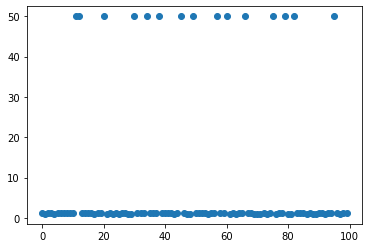

In [7]:
cumulated_reward = random_exploration(100)
plt.scatter(np.array([i for i in range(100)]),cumulated_reward)

Nos algorithmes ont à choisir parmi K bras et donnent des récompenses aux bras au fur et à mesure.

In [8]:
class Uniform(object):

    def __init__(self, K, steps):
        self.K = K
        self.steps = 0
    
    def begin(self):
        pass

    def choose(self):
        return np.random.randint(1,self.K)
    
    def reward(self, r, k):
        pass

In [9]:
class MoyenneEmpirique(object):
    """Algorithme naïf, qui utilise la moyenne empirique."""
    
    def __init__(self, K, steps):
        """Crée l'instance de l'algorithme."""
        self.K = K
        # Il nous faut de la mémoire interne
        self.recompenses = np.zeros(K)  # X_k(t) pour chaque k
        self.tirages = np.zeros(K)      # N_k(t) pour chaque k
        self.t = 0                      # Temps t interne
        self.steps = 0
    
    def begin(self):
        """Initialise l'algorithme : remet à zeros chaque X_k et N_k, et t = 0."""
        self.recompenses.fill(0)
        self.tirages.fill(0)
        self.t = 0
    
    def choose(self):
        """Si on a vu tous les bras, on prend celui de moyenne empirique la plus grande."""
        # 1er cas : il y a encore des bras qu'on a jamais vu
        if np.min(self.tirages) == 0:
            k = np.min(np.where(self.tirages == 0)[0])
        # 2nd cas : tous les bras ont été essayé
        else:
            # Notez qu'on aurait pu ne stocker que ce vecteur moyennes_empiriques
            moyennes_empiriques = self.recompenses / self.tirages
            k = np.argmax(moyennes_empiriques)
        self.t += 1      # Inutile ici
        return k
        
    def reward(self, k, r):
        """Donne une récompense r tirée sur le bras k à l'algorithme : met à jour les deux vecteurs internes."""
        self.recompenses[k] += r
        self.tirages[k] += 1

In [10]:
def simulation(algorithm, steps):
    choice, reward = np.zeros(steps), np.zeros(steps)
    algorithm.begin()  #we initialize the algorithm
    for i in range(steps):
        # On peut utiliser i comme une variable dans les algorithmes
        a=circle_points()
        x,y = a.item(0), a.item(1)
        choice_i = algorithm.choose()

        reward_i = bandit_reward(x, y, choice_i)
        
        algorithm.reward(choice_i, reward_i)  #we update the reward given to the arm in the algorithm
        choice[i], reward[i] = choice_i, reward_i
    
    return reward


def simulation_moyenne(algorithm, steps):
    choice, reward, reward_cum = np.zeros(steps), np.zeros(steps), 0
    algorithm.begin()  #we initialize the algorithm
    
    for i in range(steps):
        
        a=circle_points()
        x,y = a.item(0), a.item(1)
        choice_i = algorithm.choose()

        reward_i = bandit_reward(x, y, choice_i)
        reward_cum += reward_i
        
        algorithm.reward(choice_i, reward_i)  #we update the reward given to the arm in the algorithm
        choice[i], reward[i] = choice_i, reward_cum/(i+1)
    
    return reward

def simulation_multiple(n, algorithm, steps):
    reward = np.zeros(steps)
    for i in range(n):
        a = simulation_moyenne(algorithm, steps)
        reward += a
    return reward

In [21]:
class UCBH(MoyenneEmpirique):
    """Algorithme UCBH."""
    
    def __init__(self, K, horizon, alpha=1):
        """Crée l'instance de l'algorithme. Par défaut, alpha=1."""
        super(UCBH, self).__init__(K, steps)  # On laisse la classe mère faire le travaille
        self.horizon = int(horizon)
        self.steps = steps
        assert alpha >= 0, "Erreur : alpha doit etre >= 0."
        self.alpha = alpha
    
    def choose(self):
        """Si on a vu tous les bras, on prend celui d'indice moyenne empirique + UCB le plus grand."""
        self.t += 1      # Nécessaire ici
        # 1er cas : il y a encore des bras qu'on a jamais vu
        if np.min(self.tirages) == 0:
            k = np.min(np.where(self.tirages == 0)[0])
        # 2nd cas : tous les bras ont été essayé
        else:
            moyennes_empiriques = self.recompenses / self.tirages
            ucb = np.sqrt(self.alpha * np.log(self.horizon) / self.tirages)
            indices = moyennes_empiriques + ucb
            k = np.argmax(indices)
        return k

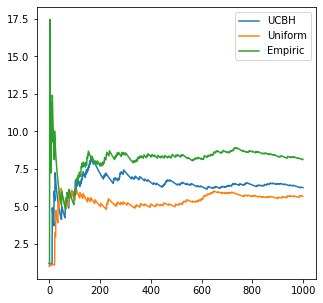

In [22]:
steps, K = 1000, 5

plt.figure(figsize=(5,5))
plt.plot(simulation_moyenne(UCBH(K, steps), steps), label="UCBH")
plt.plot(simulation_moyenne(Uniform(K, steps), steps), label="Uniform")
plt.plot(simulation_moyenne(MoyenneEmpirique(K, steps), steps), label="Empiric")
plt.legend()

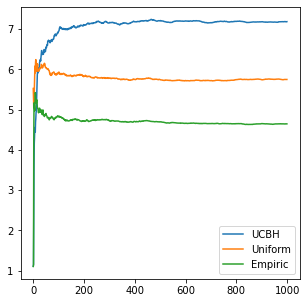

In [25]:
steps, K = 1000, 5
n = 100

plt.figure(figsize=(5,5))
plt.plot(simulation_multiple(n, UCBH(K, steps), steps)/n, label="UCBH")
plt.plot(simulation_multiple(n, Uniform(K, steps), steps)/n, label="Uniform")
plt.plot(simulation_multiple(n, MoyenneEmpirique(K, steps), steps)/n, label="Empiric")
plt.legend()

In [ ]:
class Beta():
    """Posteriors d'expériences de Bernoulli."""

    def __init__(self):
        self.N = [1, 1]

    def reinitialise(self):
        self.N = [1, 1]

    def echantillon(self):
        """Un échantillon aléatoire de ce posterior Beta."""
        return beta(self.N[1], self.N[0])

    def observe(self, obs):
        """Ajoute une nouvelle observation. Si 'obs'=1, augmente alpha, sinon si 'obs'=0, augmente beta."""
        self.N[int(obs)] += 1

In [212]:
plt.plot(simulation(n, ThompsonSampling(K, steps), steps), label="Thompson")

TypeError: 'int' object is not callable

In [32]:
class Beta(i):
    """Posteriors d'expériences de Bernoulli."""

    def __init__(self):
        self.mu_0 = 1  # On initialise mu, sigma avec 1, 1
        self.sigma_0 = 1
        self.i = 0
        self.reward_cum = 0
        self.mu = self.mu_0
        self.sigma = self.sigma_0

    def reinitialise(self):
        self.mu = self.mu_0
        self.sigma = self.sigma_0

    def echantillon(self):
        """Un échantillon aléatoire de ce posterior Beta."""
        return np.random.normal(self.mu, self.sigma, 1).item()

    def observe(self, obs):
        """Ajoute une nouvelle observation. Si 'obs'=1, augmente alpha, sinon si 'obs'=0, augmente beta."""
        self.reward_cum += obs
        i += 1
        self.mu = (1/(1/self.sigma_0**2 + self.i/(self.sigma**2)))*(self.mu_0/(self.sigma_0**2) + self.reward_cum/(self.sigma**2))
        self.sigma = 1/(1/self.sigma_0 + self.i/(self.sigma**2))

NameError: name 'i' is not defined

In [29]:
class ThompsonSampling(MoyenneEmpirique):
    """Algorithme Thompson Sampling."""
    
    def __init__(self, K, posterior=Beta):
        """Crée l'instance de l'algorithme. Par défaut, alpha=1."""
        self.K = K
        # On créé K posteriors
        self.posteriors = [posterior() for k in range(K)]
    
    def begin(self):
        """Réinitialise les K posteriors."""
        for posterior in self.posteriors:
            posterior.reinitialise()
    
    def choose(self):
        """On tire K modèles depuis les posteriors, et on joue dans le meilleur."""
        moyennes_estimees = [posterior.echantillon() for posterior in self.posteriors]
        k = np.argmax(moyennes_estimees)
        return k

    def reward(self, k, r):
        """Observe cette récompense r sur le bras k en mettant à jour le kième posterior."""
        self.posteriors[k].observe(r)

NameError: name 'Beta' is not defined

In [ ]:
class ThompsonSampling(i):
    """Algorithme Thompson Sampling."""
    #i étape d'algorithme à laquelle on se trouve

    def __init__(self, i):
        """Crée l'instance de l'algorithme. Par défaut, alpha=1."""
        self.mu_0 = 1  # On initialise mu, sigma avec 1, 1
        self.sigma_0 = 1
        self.i = i
        self.reward_cum = 0
        self.mu = self.mu_0
        self.sigma = self.sigma_0
    
    def reinitialise(self):
        self.mu = self.mu_0
        self.sigma = self.sigma_0
    
    def choose(self):
        """On tire K modèles depuis les posteriors, et on joue dans le meilleur."""
        moyennes_estimees = self.np.random.normal(self.mu, self.sigma, 1).item()
        k = np.argmax(moyennes_estimees)
        return k

    def reward(self, k, r):
        """Observe cette récompense r sur le bras k en mettant à jour le kième posterior."""
        self.posteriors[k].observe(r)

    def echantillon(self):
        """Un échantillon aléatoire de ce posterior Beta."""
        return np.random.normal(self.mu, self.sigma, 1).item()

    def observe(self, obs):
        """Ajoute une nouvelle observation. Si 'obs'=1, augmente alpha, sinon si 'obs'=0, augmente beta."""
        self.mu = (1/(1/self.sigma**2 + self.i/(self.sigma**2)))*(self.mu_0/(self.sigma_0**2) + )
        self.sigma = 1/(1/self.sigma_0 + self.i/(self.sigma**2))

In [ ]:
"""
R =[]
for i in range(10000):
    R.append(bandit_reward(0, 0, 1, 1).item())
plt.plot((np.histogram(R, bins=100))[0])
"""